# Исследование влияния архитектурных изменений сверточной нейронной сети на качество распознавания на примере набора CIFAR-10

**Проведите ряд экспериментов с архитектурой нейронной сети:**

1. Исследуйте влияние количества слоев `Conv2D`.
2. Исследуйте влияние количества нейронов.
3. Исследуйте влияние `MaxPooling2D` в сети.
4. Исследуйте влияние `Dropout`.
5. Напишите выводы по результатам проведенных тестов.

In [1]:
import logging
import os
from pathlib import Path
import sys
from typing import Callable, List, Optional

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.callbacks import History
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,  
    Dropout, 
    Flatten,
    MaxPooling2D
)
from tensorflow.keras.optimizers import Adam

from PIL import Image
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

Установить уровень диагностических сообщений для TensorFlow.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Отобразить список доступных устройств.

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Задать количество эпох для обучения.

In [4]:
EPOCHS = 40

Создать датафрейм для хранения результатов тестирования.

In [5]:
report = pd.DataFrame(
    index=pd.MultiIndex.from_tuples([], names=("Категория", "Значение")),
    columns=['train', 'validation', 'test']
)

Определить вспомогательную функцию для визуализации процесса обучения.

In [6]:
def plot_history(
    history: History, 
    subtitle: str, 
    axes: Optional[np.ndarray] = None
) -> None:
    if axes is None or not axes.all():
        _, axes = plt.subplots(1, 2, figsize=(12, 5))
        show_plot = True
    else:
        show_plot = False

    axes[0].plot(
        history.epoch,
        history.history['loss'],
        color='steelblue',
        label='train set'
    )
    axes[0].plot(
        history.epoch,
        history.history['val_loss'],
        color='darkblue',
        label='validation set'
    )
    axes[0].set_title(f"Изменение loss: {subtitle}")
    axes[0].set_ylabel('loss')
    axes[0].set_xlabel('epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        history.epoch,
        history.history['accuracy'],
        color='salmon',
        label='train set'
    )
    axes[1].plot(
        history.epoch,
        history.history['val_accuracy'],
        color='darkred',
        label='validation set'
    )
    axes[1].set_title(f"Изменение accuracy: {subtitle}")
    axes[1].set_ylabel('accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].grid(True)
    axes[1].legend()

    if show_plot:
        plt.show()

Задать путь для сохранения моделей нейронных сетей.

In [7]:
path = Path.home() / 'aiu-03-cifar-10-pro-models'
if not path.exists():
    Path.mkdir(path, parents=True)

## Подготовка данных

Загрузка данных CIFAR-10:

In [8]:
(x_org, y_org), (x_test_org, y_test_org) = cifar10.load_data()

In [9]:
print(f"{x_org.shape}, {x_test_org.shape}")

(50000, 32, 32, 3), (10000, 32, 32, 3)


Задать наименования меток CIFAR-10:

In [10]:
names = [
    "Самолет",  # airplane : 0
    "Автомобиль",  # automobile : 1
    "Птица",  # bird : 2
    "Кошка",  # cat : 3
    "Олень",  # deer : 4
    "Собака",  # dog : 5
    "Лягушка",  # frog : 6
    "Лошадь",  # horse : 7
    "Корабль",  # ship : 8
    "Грузовик",  # truck : 9
]

Отобразить примеры цифр из набора

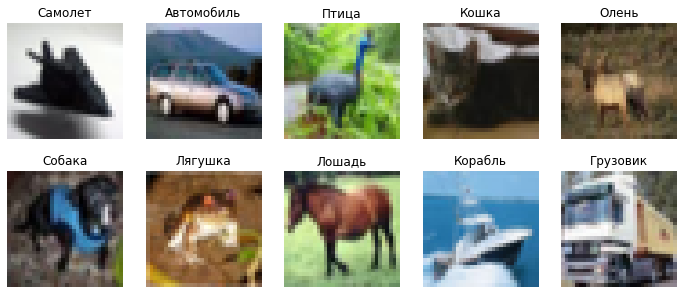

In [11]:
labels = np.unique(y_org)

_, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for label, ax in zip(labels, axes):
    ax.imshow(
        Image.fromarray(x_org[(y_org == label).flatten()][0]).convert('RGB')
    )

    ax.set_title(names[label])
    ax.set_axis_off()

plt.show();

Изменить формат входных изображений:

In [12]:
x = x_org.copy() / 255
x_test = x_test_org.copy() / 255

In [13]:
print(f"{x.shape}, {x_test.shape}")

(50000, 32, 32, 3), (10000, 32, 32, 3)


Преобразовать ответы в унитарный код (one-hot)

In [14]:
y = utils.to_categorical(y_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

In [15]:
print(f"{y.shape}, {y_test.shape}")

(50000, 10), (10000, 10)


Выделить обучающую и валидационную выборки.

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=5000)

In [17]:
print(f"{x_train.shape}, {x_val.shape}")

(45000, 32, 32, 3), (5000, 32, 32, 3)


## Создание и обучение эталонной модели сверточной нейронной сети

Вспомогательный класс для создания нейронной сети заданной архитектуры.

In [62]:
class ConvNet:

    @staticmethod
    def build(
        max_depth: int,
        layer_functor: Callable[[int], int]=lambda depth: 32 * (1 << (depth >> 1)),
        dropout_rate: float=0.25,
        use_pooling: bool=True
    ) -> Sequential:
        if max_depth < 1:
            raise RuntimeError("Illegal maximal depth of the neural network")

        model = Sequential()

        model.add(BatchNormalization(input_shape=(32, 32, 3)))

        neurons = layer_functor(1)
        if neurons <= 0:
            raise RuntimeError("Illegal neurons number on the depth 1")
        model.add(
            Conv2D(
                neurons,
                (3, 3),
                padding='same',
                input_shape=(32, 32, 3)
            )
        )
        model.add(Activation('relu'))

        for depth in range(2, max_depth + 1):
            neurons = layer_functor(depth)
            if neurons <= 0:
                raise RuntimeError(f"Illegal neurons number on the depth {depth}")

            model.add(Conv2D(neurons, (3, 3), padding='same'))
            model.add(Activation('relu'))

            if not depth & 1:
                if use_pooling:
                    model.add(MaxPooling2D(pool_size=(2, 2)))
                if dropout_rate > 0.0:
                    model.add(Dropout(dropout_rate))

        if dropout_rate > 0.0 and max_depth & 1:
            model.add(Dropout(dropout_rate))

        model.add(Flatten())

        for i in range(4):
            model.add(Dense(0x40 << i))
            model.add(Activation('relu'))
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate))

        model.add(Dense(10))
        model.add(Activation('softmax'))

        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(),
            metrics=['accuracy']
        )

        return model

Создать эталонную модель сверточной нейронной сети. Источник: [CIFAR-10 Image Classification in TensorFlow](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c).

In [63]:
reference_net = ConvNet.build(max_depth=9)

print(reference_net.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_34 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_262 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_432 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_263 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_433 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_116 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_282 (Dropout)        (None, 16, 16, 64)      

Обучить нейронную сеть.

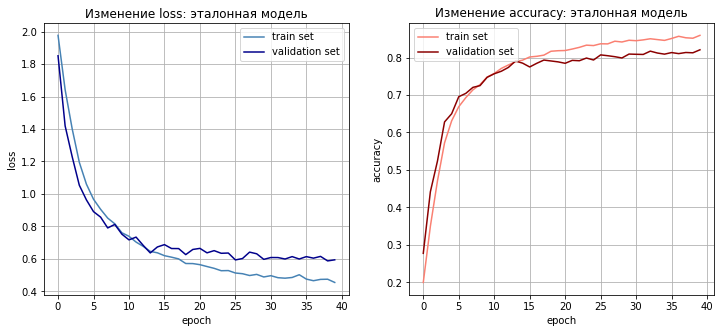

In [20]:
history = reference_net.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    verbose=0
)

plot_history(history, subtitle="эталонная модель");

Сохранить архитектуру нейронной сети.

In [21]:
reference_net.save(path / 'aiu-03-cifar-10-pro-model-reference')

Получить значения loss и accuracy для тестовой выборки.

In [22]:
score = reference_net.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {score[0]:.5f}\nTest accuracy: {score[1]:.5f}")

Test loss: 0.61295
Test accuracy: 0.81570


Распознать какое-либо изображение из тестового набора.

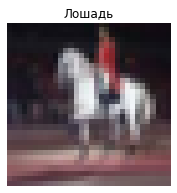


Предсказанная метка класса: Лошадь


In [38]:
idx = np.random.randint(0, x_test.shape[0])

_, ax = plt.subplots(figsize=(3, 3))

ax.imshow(
    Image.fromarray(x_test_org[idx]).convert('RGB')
)

ax.set_title(names[y_test_org[idx][0]])
ax.set_axis_off()

plt.show();

y_pred = np.argmax(reference_net.predict(x_test[idx][np.newaxis, :, :, :]))
print(f"\nПредсказанная метка класса: {names[y_pred]}")

Записать результаты в отчет.

In [23]:
def update_report(
    report: pd.DataFrame,
    category: str,
    value: str,
    history: History,
    score: List[int]
) -> None:
    report.loc[(category, value), :] = [
        history.history['accuracy'][-1],
        history.history['val_accuracy'][-1],
        score[1]
    ]

In [24]:
update_report(report, "Эталонная модель", "9", history, score)

## Исследование влияния количества сверточных слоев

Будем последовательно добавлять сверточные слои к нейронной сети с эталонной архитектурой для определения влияния количества серточных слоев на качество распознавания.

Done: 100%|██████████| 8/8 [20:39<00:00, 154.99s/it]


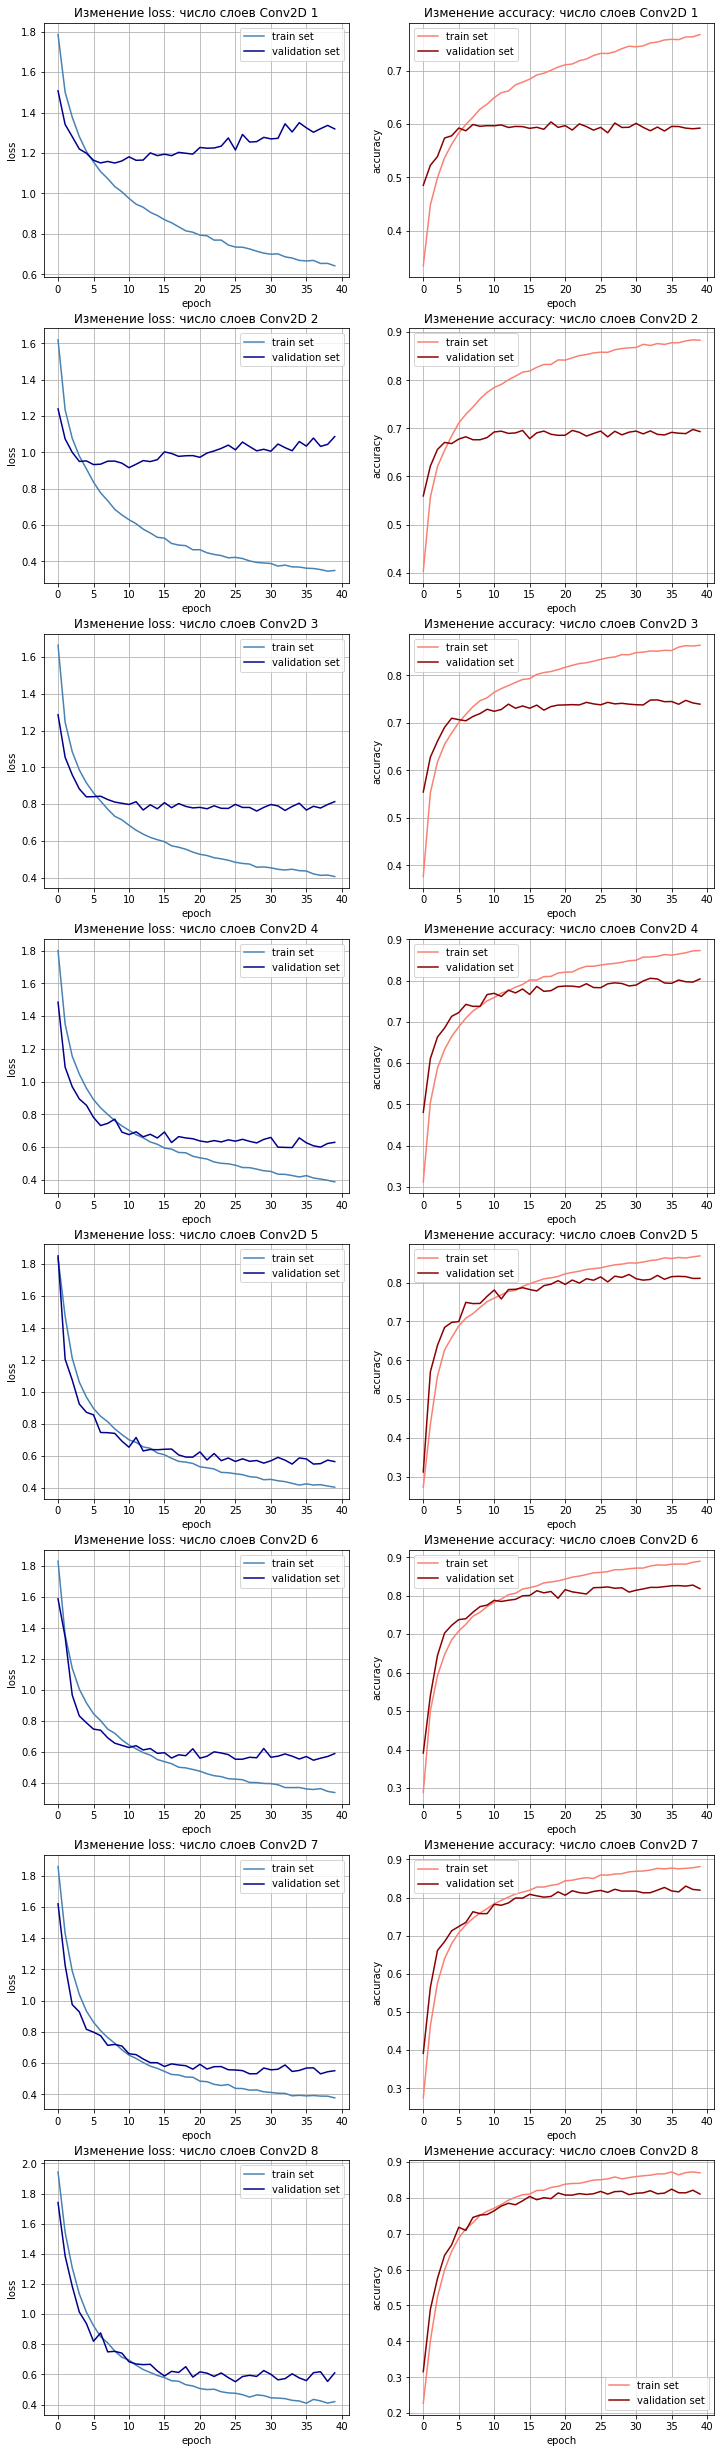

In [40]:
max_depths = tuple(range(1, 9))

_, axes = plt.subplots(
    len(max_depths), 
    2,
    figsize=(12, 5.5 * len(max_depths))
)
axes = axes.flatten()

with tqdm(total=len(max_depths), desc="Fitting", file=sys.stdout) as pbar:
    for i, max_depth in enumerate(max_depths):
        net = ConvNet.build(max_depth=max_depth)

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle=f"число слоев Conv2D {max_depth}",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-max-depth-{max_depth}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Количество сверточных слоев",
            str(max_depth),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

## Исследование влияния количества нейронов

Для начала произведем исследование в том случае, когда во всех сверточных слоях одинаковое количество нейронов.

In [49]:
neurons_numbers = tuple(0x4 << i for i in range(7))
print(neurons_numbers)

(4, 8, 16, 32, 64, 128, 256)


Done: 100%|██████████| 7/7 [28:36<00:00, 245.18s/it]


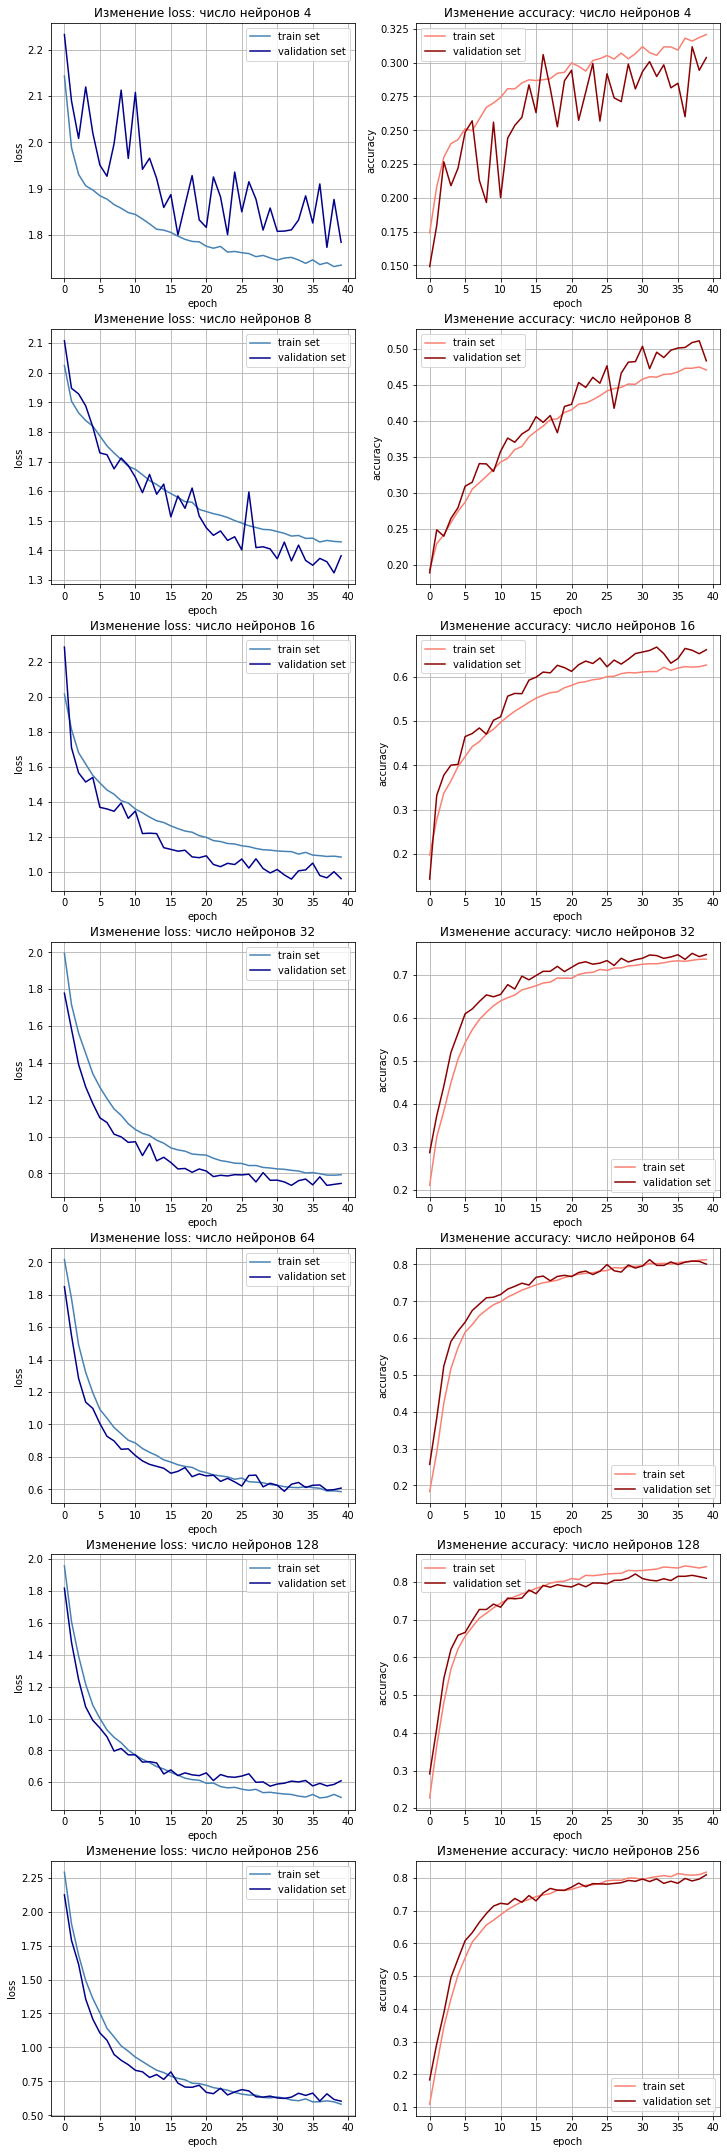

In [50]:
_, axes = plt.subplots(
    len(neurons_numbers), 
    2,
    figsize=(12, 5.5 * len(neurons_numbers))
)
axes = axes.flatten()

with tqdm(total=len(neurons_numbers), desc="Fitting", file=sys.stdout) as pbar:
    for i, neurons_number in enumerate(neurons_numbers):
        net = ConvNet.build(
            max_depth=9, 
            layer_functor=lambda _: neurons_number
        )

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle=f"число нейронов {neurons_number}",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-neurons-{neurons_number}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Количество нейронов",
            str(neurons_number),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

Исследование влияния размера шага при аддитивной стратегии увеличения количества нейронов в сверточных слоях. В каждом последующем слое число нейронов увеличивается на константу по сравнению с числом нейронов в текущем слое.

In [56]:
deltas = tuple(0x1 << i for i in range(7))
print(deltas)

(1, 2, 4, 8, 16, 32, 64)


Done: 100%|██████████| 7/7 [24:06<00:00, 206.57s/it]


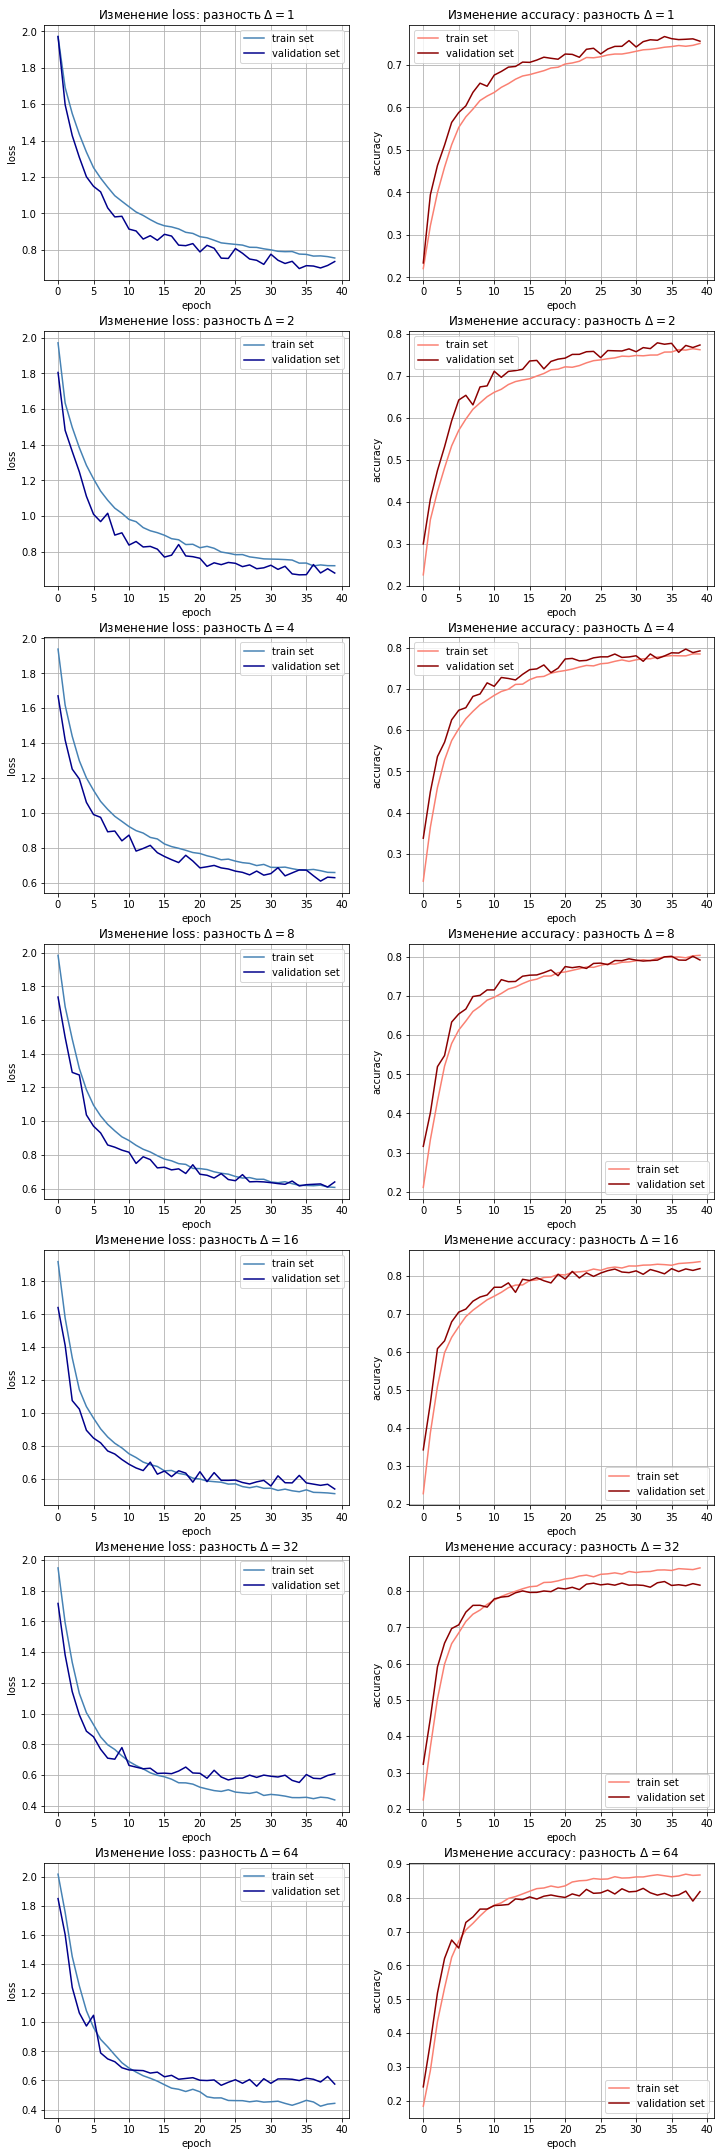

In [57]:
_, axes = plt.subplots(
    len(deltas), 
    2,
    figsize=(12, 5.5 * len(deltas))
)
axes = axes.flatten()

with tqdm(total=len(deltas), desc="Fitting", file=sys.stdout) as pbar:
    for i, delta in enumerate(deltas):
        net = ConvNet.build(
            max_depth=9, 
            layer_functor=lambda depth: 32 + delta * (depth - 1)
        )

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle=f"разность $\Delta = {delta}$",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-delta-{delta}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Аддитивная стратегия",
            str(delta),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();

Исследование влияния величины коэффициента при мультипликативной стратегии увеличения количества нейронов в сверточных слоях. В каждом последующем слое число нейронов увеличивается в некоторое число раз по сравнению с числом нейронов в текущем слое.

In [61]:
multipliers = np.linspace(1.1, 2, num=7)
print(multipliers)

[1.1  1.25 1.4  1.55 1.7  1.85 2.  ]


In [ ]:
_, axes = plt.subplots(
    len(multipliers), 
    2,
    figsize=(12, 5.5 * len(multipliers))
)
axes = axes.flatten()

with tqdm(total=len(multipliers), desc="Fitting", file=sys.stdout) as pbar:
    for i, multiplier in enumerate(multipliers):
        net = ConvNet.build(
            max_depth=9, 
            layer_functor=lambda depth: round(32 * multiplier ** (depth - 1)),
        )

        history = net.fit(
            x_train,
            y_train,
            batch_size=128,
            epochs=EPOCHS,
            validation_data=(x_val, y_val),
            verbose=0
        )
        plot_history(
            history, 
            subtitle=f"коэффициент $\k = {multiplier}$",
            axes=axes[2*i:2*i+2]
        )

        net.save(path / f'aiu-03-cifar-10-pro-model-mult-{multiplier}')

        score = net.evaluate(x_test, y_test, verbose=0)
        update_report(
            report,
            "Мультипликативная стратегия",
            str(multiplier),
            history,
            score
        )

        pbar.update()
        pbar.refresh()

    pbar.set_description("Done")

plt.show();